In [2]:
# Rastering and direction extraction
library(networkDynamic)
library(tidygraph)
library(sfnetworks)
library(stplanr)
library(dodgr)
library(raster)
library(rasterize)
# necessary packages
library(gstat)   # geostatistics
library(sf)      # spatial data handling
library(sp)       # spatial data handling
library(ggplot2) # for ploting
library(ggmap)    # maps
library(dplyr)    # data manipulation
library(tidyr)     # data manipulation
library(tidyverse) # data manipulation
library(tsibble)   # data maipulation
library(ggpubr)    # visualisation
library(geosphere) # geo maps
library(RColorBrewer)  # data visualisation
library(maptools)  # geo maps
library(geodist)   # geo maps
library(rnaturalearth) # river data
library(viridis)   # data visualisation
library(scatterpie) # data visualisation
library(circular) # coordinates
library(Hmisc) # statistics
library(reshape2) # data manipulation
library(mapview)
#library(ggspatreg)
library(ggdensity)
library(svglite)

mapviewOptions(fgb = F)

Warning message:
“option 'fgb' requires GDAL >= 3.1.0! Your version is 3.0.4. Setting fgb = FALSE”


In [3]:
data <- read.csv(file = "/home/thomas/Documents/post-doc/cingulata/research/master-population-screening/maps/summary.csv")
data <- data |> aggregate(cbind(wCin1,wCin2) ~ locality+ population+lat+lon, sum) |> as_tibble()
# extract map of Europe from openmaps
#map <- get_map(location = c(-15.0, 40.0, 30.0, 60.0), color = "color")

data <- data |> as_tibble() |> mutate(infection = wCin1/wCin2) |> mutate(total = wCin2) |> mutate(wCin2 = total - wCin1)
sum(data$total)

[1] 1130

In [4]:
### pie maps

map <- get_stamenmap( bbox = c(left = -3, bottom = 43, right = 22, top = 57), zoom = 4, maptype = "toner-background")

mapatt <- attributes(map)
map_transparent <- matrix(adjustcolor(map, alpha.f = 0.4), nrow = nrow(map))
attributes(map_transparent) <- mapatt
# plot and remove the grid
mygmap <- ggmap(map_transparent) +
    theme(panel.grid = element_blank(), panel.background = element_rect(fill = 'white'))

ℹ Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.



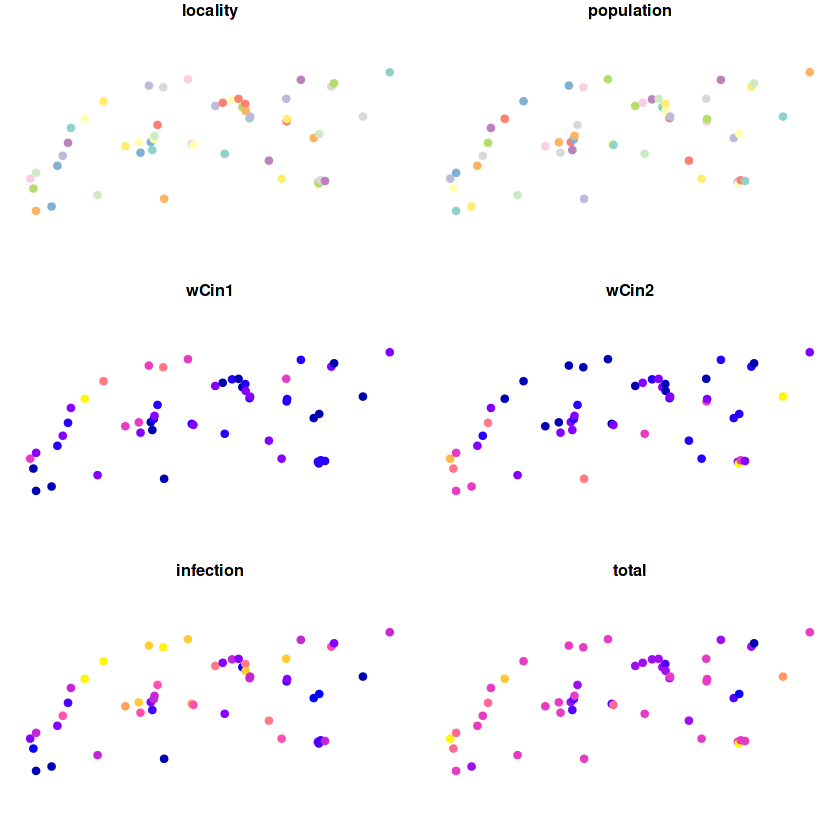

In [5]:
# Spacial point mapview test
data.sp <- st_as_sf(x = data, coords = c("lon", "lat"))
mapview(data.sp, zcol = 'infection')
plot(data.sp, pch = 19)

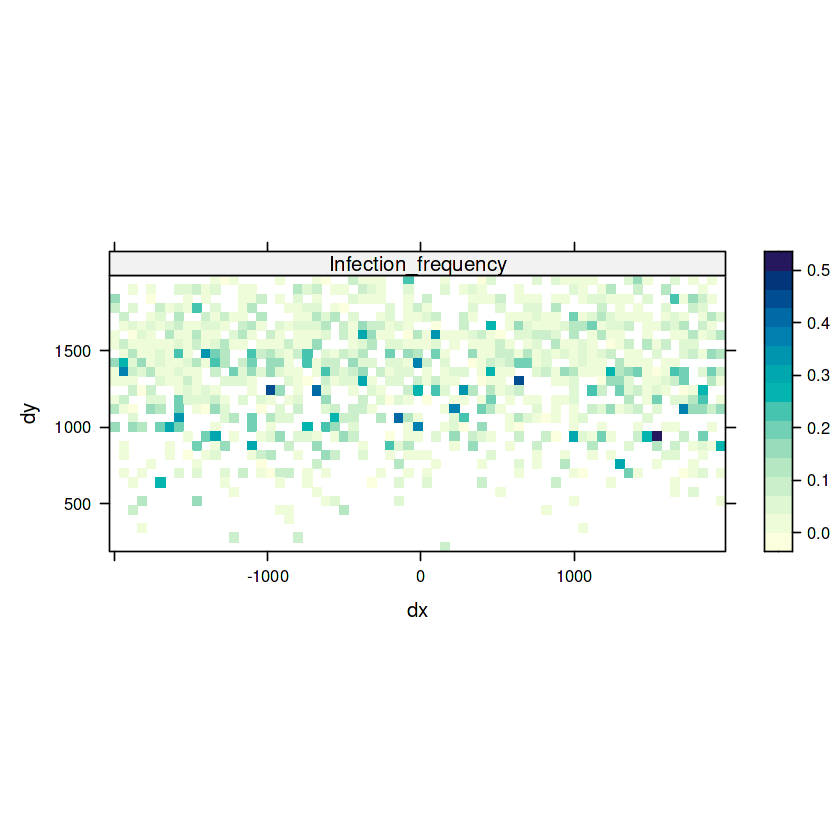

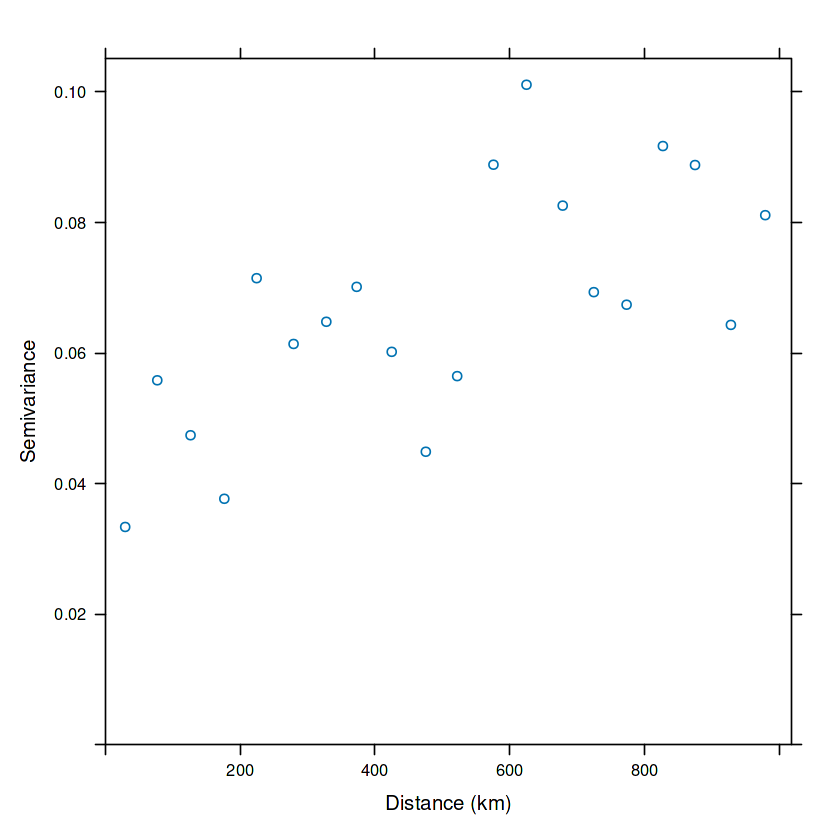

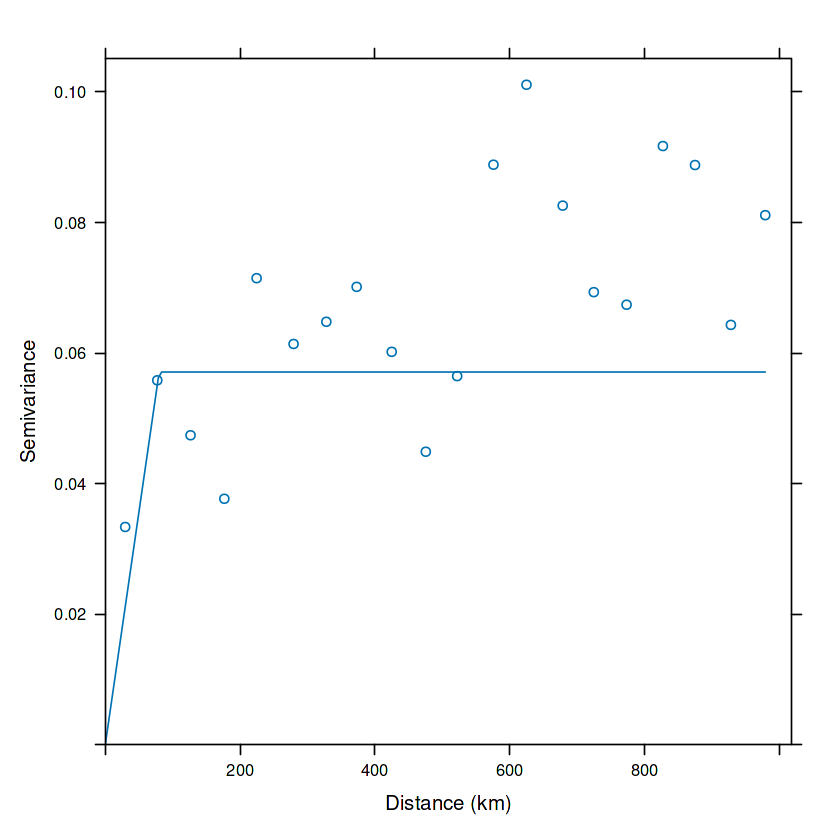

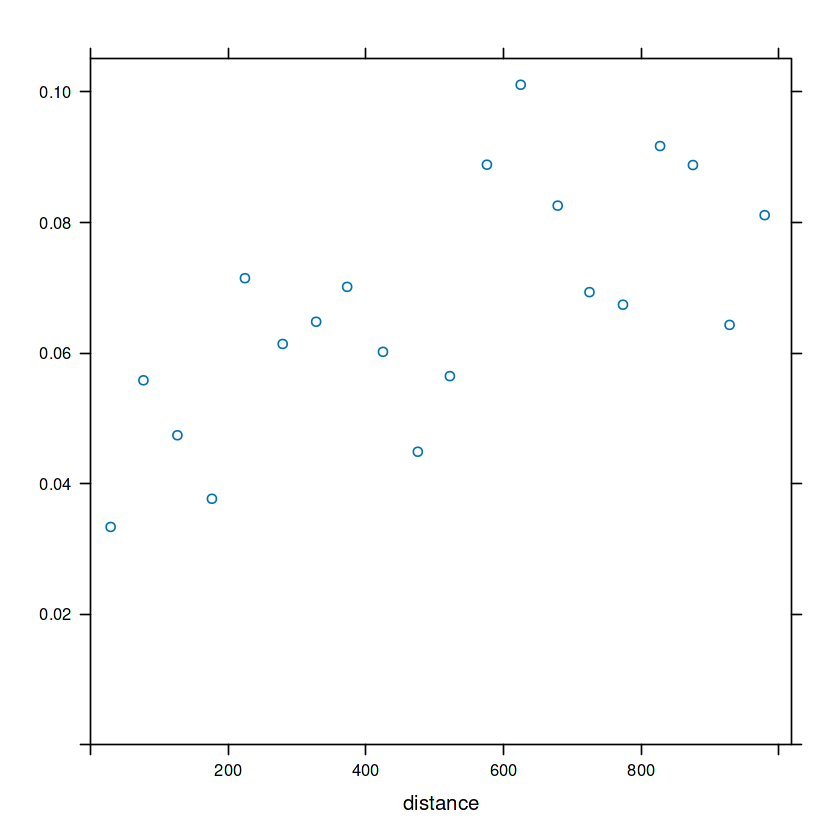

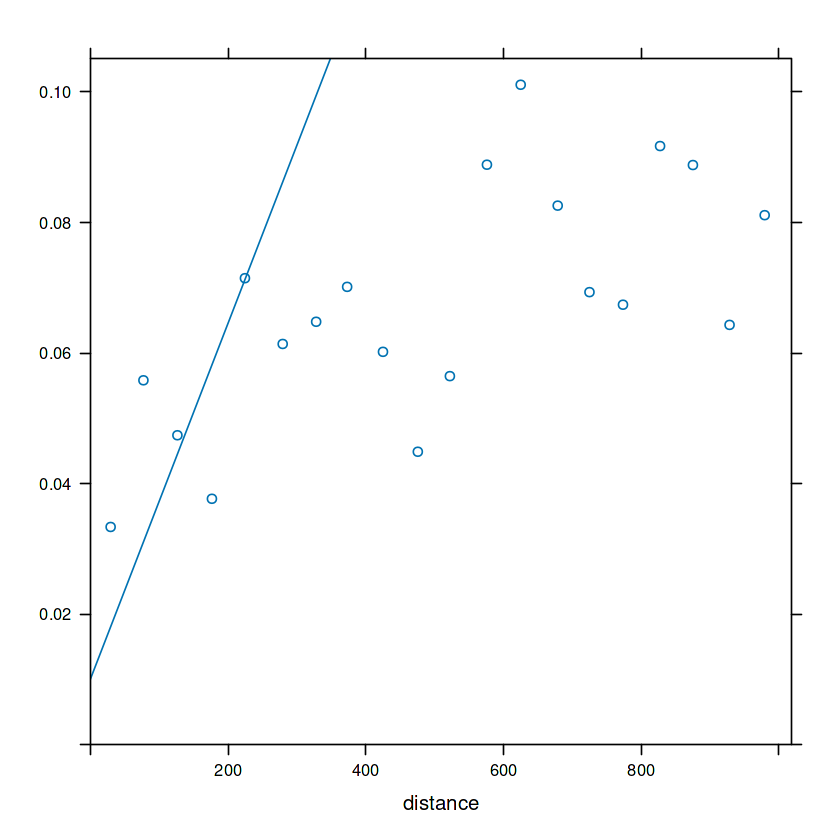

In [6]:
# variogram & kriging

sf_ob <- st_as_sf(x = data,
                  coords = c("lon", "lat"),
                  crs = "+proj=longlat") #+datum=WGS84 +ellps=WGS84 +towgs84=0,0,0

bbox <- st_bbox(sf_ob)

sf_ob_grid <- sf_ob |> 
  st_bbox() |>     # determines bounding box coordinates from sf_ob
  st_as_sfc() |>   # creates sfc object from bounding box
  st_make_grid(     # create grid 0.1 x 0.1 pixel size
    cellsize = c(0.1, 0.1), 
    what = "centers") |>
  st_as_sf(crs=st_crs(sf_ob)) # convert to sf object
### Convert sf_ob samples to SpatialPointsDataFrame
sf_ob_sp <- as(sf_ob, "Spatial")

### Convert sf_ob grid to SpatialPixelsDataFrame, the raster/grid equivalent in the sp world
sf_ob_grid_sp <- as(as(sf_ob_grid, "Spatial"), "SpatialPixels")


TheGStat <- gstat(id="Infection_frequency", formula=infection ~ 1, data=sf_ob)

TheVariogram=variogram(TheGStat, map=TRUE, cutoff=2000, width=60)
## check whether there is a north-south, etc. trend with a variogram map
plot(TheVariogram, threshold=1)

#Create directional empirical variograms at 0, 45, 90, 135 degrees from north (y-axis)
sf_ob.aniso <- gstat::variogram(infection~ 1, sf_ob, cressie = T, cutoff = 1000, width = 50, alpha = c(0, 45, 90, 135))
sf_ob.aniso <- gstat::variogram(infection~ 1, sf_ob, cressie = T, cutoff = 1000, width = 50, alpha = 45)
# plot the empirical variograms
plot(sf_ob.aniso, xlab = "Distance (km)", ylab = "Semivariance")

# Now choose a model - I choose the exponential model here
TheModel=vgm(model='Lin' , anis=c(45,0.5))
# Fit the model to the variogram
FittedModel <- fit.variogram(sf_ob.aniso, model=TheModel)
## plot results
plot(sf_ob.aniso, model=FittedModel, as.table=TRUE, xlab = "Distance (km)", ylab = "Semivariance")

vgm.45 <- subset(sf_ob.aniso, sf_ob.aniso$dir.hor == 45)  # Subset the variogram data for just this direction
plot(vgm.45)

eye.lin <- vgm(0.3, "Lin", 1100, 0.01)
plot(vgm.45, eye.lin)

Warning message in fit.variogram(sf_ob.v, sf_ob.wav):
“singular model in variogram fit”


[using ordinary kriging]


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“Removed 2139 rows containing non-finite values (`stat_contour()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_pie()`).”
Warning message:
“Removed 2139 rows containing non-finite values (`stat_contour()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_pie()`).”


png 
  2

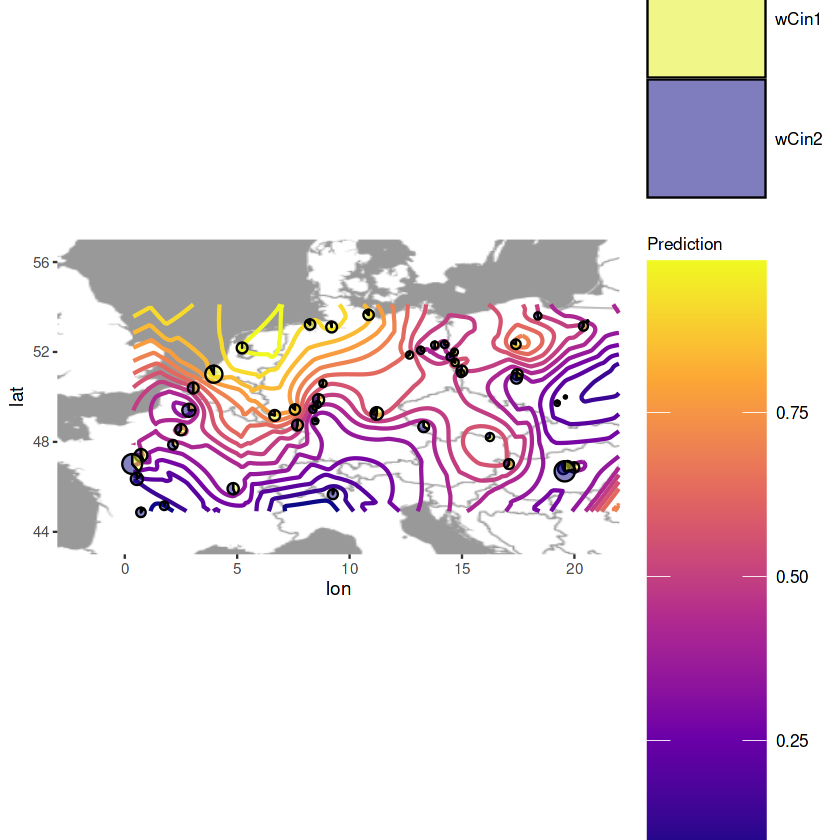

In [7]:
###### make kriging function to test different parameters and models #########
mykrige <- function(data, formula, model, inits1, inits2) {
  
  # create and sf object
  sf_ob <- st_as_sf(x = data,
                    coords = c("lon", "lat"),
                    crs = "+proj=longlat") #+datum=WGS84 +ellps=WGS84 +towgs84=0,0,0
  
  bbox <- st_bbox(sf_ob)
  
  # create a grid
  sf_ob_grid <- sf_ob |> 
    st_bbox() |>     # determines bounding box coordinates from sf_ob
    st_as_sfc() |>   # creates sfc object from bounding box
    st_make_grid(     # create grid 0.1 x 0.1 pixel size
      cellsize = c(0.1, 0.1), 
      what = "centers") |>
    st_as_sf(crs=st_crs(sf_ob)) # convert to sf object
  
  ### Convert sf_ob samples to SpatialPointsDataFrame
  sf_ob_sp <- as(sf_ob, "Spatial")
  
  ### Convert sf_ob grid to SpatialPixelsDataFrame, the raster/grid equivalent in the sp world
  sf_ob_grid_sp <- as(as(sf_ob_grid, "Spatial"), "SpatialPixels")
  
  sf_ob.v <- gstat::variogram(formula, sf_ob, cressie = T, cutoff = inits1[1], width = inits1[2], alpha = 45)
  sf_ob.wav <- vgm(psill=inits2[1], model = model, range = inits2[2], nugget=inits2[3], covariance = T) 
  
  sf_ob.vfit <- fit.variogram(sf_ob.v, sf_ob.wav)
  sf_ob.vfit
  #plot(sf_ob.vfit)
  
  ### ordinary kriging
  prediction <- krige(formula = formula, sf_ob_sp, sf_ob_grid_sp, sf_ob.vfit)
  prediction
  
}
# call the function with chosen set of parameters based on the theoretical prediction
mk <- mykrige(data=data, formula=infection ~ 1, model="Lin", inits1=c(1000, 50), inits2 = c(0.3, 1100, 0.01)) # numbers identified earlier

# Coerce raster to dataframe, including coordinates
mk.df <- mk %>% as("SpatialPixelsDataFrame") %>% as.data.frame
d <- data |> as.data.frame()

# plot kriging predicted contour lines on the map with Danube river
d$radius = d$total*0.01
krigplot <- mygmap +
  geom_contour(data=mk.df, aes(x=coords.x1, y=coords.x2, z = var1.pred, colour = after_stat(level)), 
               binwidth = 0.07,
               linewidth = 0.9) + 
  scale_color_viridis_c("Prediction", option = "plasma") + 
  geom_scatterpie(data = d, aes(x=lon, y=lat, group=locality, r=radius), cols = c("wCin1", "wCin2"), alpha=.5) +  coord_equal() +
  scale_fill_manual(values=c("#F0F921FF", "#0D0887FF")) +
  #geom_point(data=mk.df.s, aes(x=coords.x1, y=coords.x2, z = var1.var)) +
  theme(legend.title = element_text(size = 10), 
        legend.text = element_text(size = 10),
        legend.key.size = unit(1, 'in'))

krigplot
svglite("myplot.svg")
krigplot
dev.off()

mk.df.s <- mk.df |> as_tibble() |> sample_n(500) # dataframe that has imputed frequencies.


ERROR while rich displaying an object: Error in `geom_point()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'value' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)

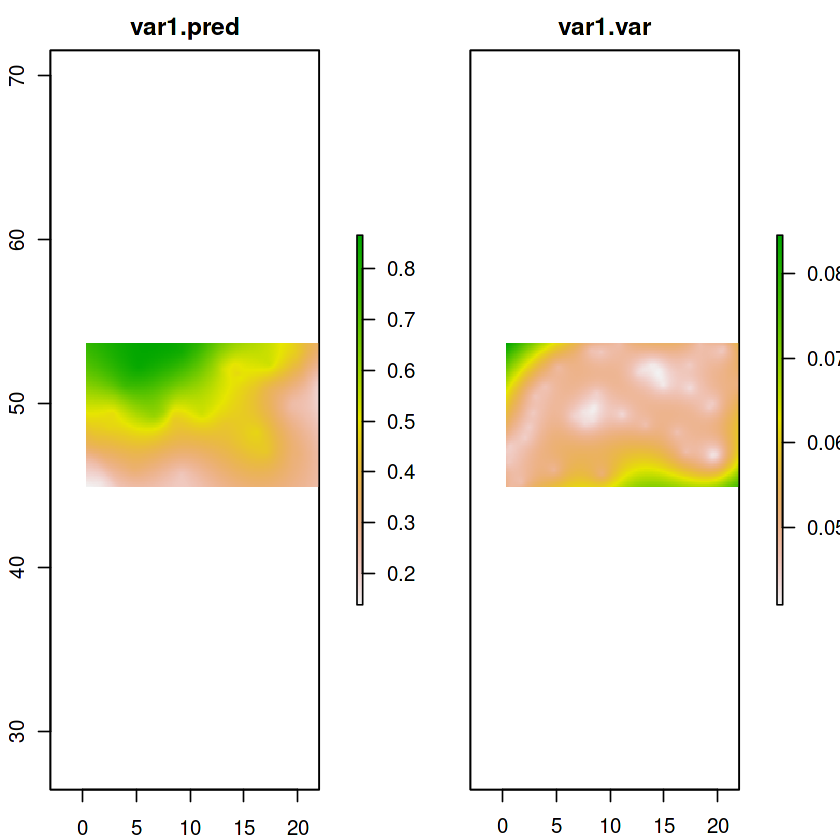

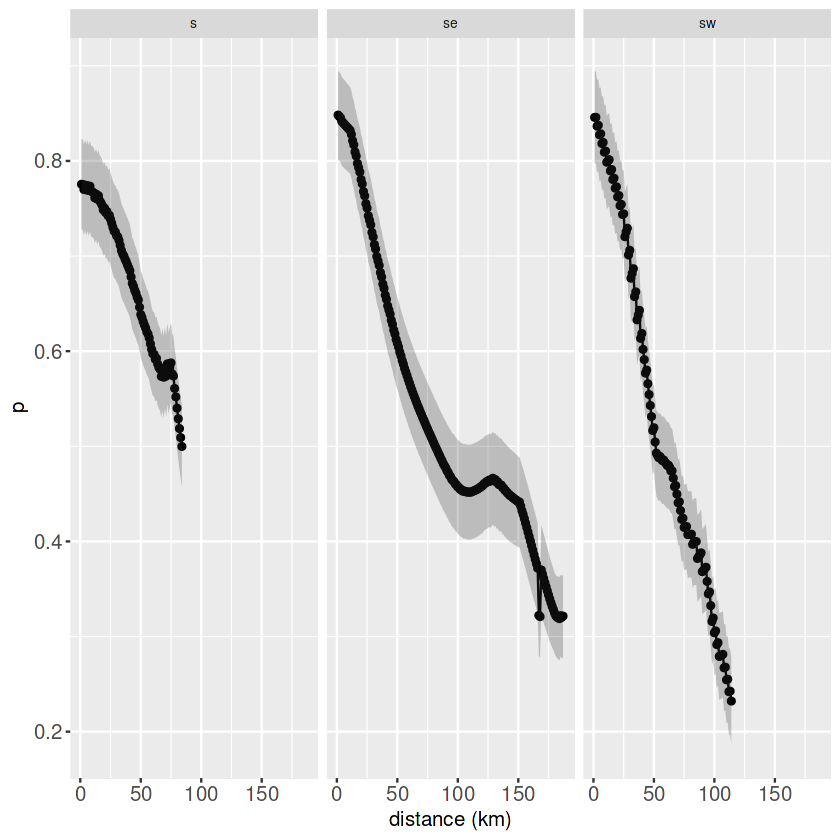

In [18]:
# Make raster
r_obj <- raster(xmn=-3, xmx=22, ymn=44, ymx=54, resolution=c(0.1,0.1))
r_data <- rasterize(x=mk.df[, 1:2], # lon-lat data
                    y=r_obj, # raster object
                    field=mk.df[, 3:4], # vals to fill raster with mk.df[, 3:4] for prediction and variance
                    fun=mean)
r <- r_data

# extract the directions for clines
sw_cline <- data |> as.data.frame() |> filter(lat < 53.0, lat > 45.0, lon < 6) |> filter(locality != "Parcieux", locality != "Beynat") |> arrange(lon)
s_cline <- data |> as.data.frame() |> filter(locality %in% c("Salem","Ramstein","Haguenau","Monza-Brianza")) |> arrange(lat)
se_cline <- data |> as.data.frame() |> filter(locality %in% c("Rastede","Sottrum","Bugac","Helvecia","Turje","Aicha-vorm-Wald", "Kecskemet", "Szentkiraly")) |> arrange(lon)
e_cline <- data |> as.data.frame() |> filter(lat < 53.0, lat > 45.0, lon < 6) |> filter(locality != "Parcieux", locality != "Beynat") |> arrange(lon)

line_sw = SpatialLines(list(Lines(Line(cbind(sw_cline$lon,sw_cline$lat)), ID="a")))
line_s = SpatialLines(list(Lines(Line(cbind(s_cline$lon,s_cline$lat)), ID="a")))
line_se = SpatialLines(list(Lines(Line(cbind(se_cline$lon,se_cline$lat)), ID="a")))
line_e = SpatialLines(list(Lines(Line(cbind(e_cline$lon,e_cline$lat)), ID="a"))) # FILL UP WITH POLAND

epsg.32721 <- "+proj=utm +zone=21 +south +datum=WGS84 +units=m +no_defs"
spatialLinesObject_sw <- SpatialLines(LinesList = list(Lines(slinelist = list(Line(coords = cbind(sw_cline$lon, sw_cline$lat))), ID = "1")), proj4string = CRS(epsg.32721))
spatialLinesObject_s <- SpatialLines(LinesList = list(Lines(slinelist = list(Line(coords = cbind(s_cline$lon, s_cline$lat))), ID =  "1")), proj4string = CRS(epsg.32721))
spatialLinesObject_se <- SpatialLines(LinesList = list(Lines(slinelist = list(Line(coords = cbind(se_cline$lon, se_cline$lat))), ID = "1")), proj4string = CRS(epsg.32721))

spatialPointsObject_sw <- SpatialPoints(coords = cbind(sw_cline$lon, sw_cline$lat), proj4string = CRS(epsg.32721))
spatialPointsObject_s <- SpatialPoints(coords = cbind(s_cline$lon, s_cline$lat), proj4string = CRS(epsg.32721))
spatialPointsObject_se <- SpatialPoints(coords = cbind(se_cline$lon, se_cline$lat), proj4string = CRS(epsg.32721))

plot(r_data)
plot(spatialPointsObject_sw, col = "blue", pch = 19, add = TRUE)
plot(spatialPointsObject_s, col = "purple", pch = 19, add = TRUE)
plot(spatialPointsObject_se, col = "red", pch = 19, add = TRUE)
plot(spatialLinesObject_sw, xlab = "Longitude", ylab = "Latitude", main = "SpatialPoints + SpatialLines", add = T, col = "blue")
plot(spatialLinesObject_s, xlab = "Longitude", ylab = "Latitude", main = "SpatialPoints + SpatialLines", add = T, col = "purple")
plot(spatialLinesObject_se, xlab = "Longitude", ylab = "Latitude", main = "SpatialPoints + SpatialLines", add = T, col = "red")
#plot(spatialLinesObject_e, xlab = "Longitude", ylab = "Latitude", main = "SpatialPoints + SpatialLines", add = T)
#plot(line, add = T, col = "blue")

vals_sw <- raster::extract(r, line_sw)[[1]] |> as_tibble() |> add_column(distance = 1:dim(raster::extract(r, line_sw)[[1]])[1], .before = "var1.pred") |> add_column(direction = "sw", .before = "var1.pred")
vals_sw_p <- ggplot(vals_sw, aes(x = distance, y = value)) +
    geom_point(size=2, color = "blue")

vals_s <- raster::extract(r, line_s)[[1]] |> as_tibble() |> add_column(distance = 1:dim(raster::extract(r, line_s)[[1]])[1], .before = "var1.pred") |> add_column(direction = "s", .before = "var1.pred")
vals_s_p <- ggplot(vals_s, aes(x = distance, y = value)) +
    geom_point(size=2, color = "purple")

vals_se <- raster::extract(r, line_se)[[1]] |> as_tibble() |> add_column(distance = 1:dim(raster::extract(r, line_se)[[1]])[1], .before = "var1.pred") |> add_column(direction = "se", .before = "var1.pred")
vals_se_p <- ggplot(vals_se, aes(x = distance, y = value)) +
    geom_point(size=2, color = "red")

vals <- bind_rows(vals_se, vals_sw, vals_s)
vals_p <- ggplot(vals, aes(x = distance, y = value, color = direction)) +
    geom_point(size=1)
vals_p

v1 <- ggplot(vals, aes(x = distance, y = var1.pred))
v1 <- v1 + geom_point() +
    labs(x = "distance (km)", y = "p") +
    theme(text = element_text(size = 12), axis.text = element_text(size = 12),
          legend.position = "none", strip.text = element_text(size = 8))
v1 + geom_line(aes(x = distance, y = var1.pred)) +
    geom_ribbon(aes(ymin = var1.pred - var1.var, ymax = var1.pred + var1.var), alpha = 0.25) +
    facet_wrap(~factor(direction))
#plot_grid(vals_sw_p, vals_s_p, vals_se_p)